In [3]:
import pandas as pd
import unicodedata
import ftfy
import gensim
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary

In [4]:
df = pd.read_csv ('./data/seek_australia.csv')
df = df.sample(frac = 0.1, random_state=42)
df

,category,city,company_name,geo,job_board,job_description,job_title,job_type,post_date,salary_offered,state,url
2308,Consulting & Strategy,Brisbane,RACQ,AU,seek,Â Lead and develop team of Pricing Analysts ...,Manager Pricing,Full Time,2018-04-16T02:48:56Z,NaN,Southern Suburbs & Logan,https://www.seek.com.au/job/35992845
22404,Trades & Services,Adelaide,Extrastaff,AU,seek,"Backed by the Australian Chamber movement,Â E...",Experienced Bakers,Casual/Vacation,2018-04-12T02:23:53Z,NaN,NaN,https://www.seek.com.au/job/35967419
23397,Accounting,Brisbane,Boeing Defence Australia,AU,seek,"Boeing Defence Australia Ltd, a wholly owned ...",Contracts Manager,Full Time,2018-04-12T03:45:02Z,NaN,CBD & Inner Suburbs,https://www.seek.com.au/job/35968503
25058,Hospitality & Tourism,Gold Coast,Jora Local,AU,seek,A restaurant in Runaway Bay is seeking a casu...,Casual Cook in Runaway Bay,Casual/Vacation,2018-04-12T07:35:02Z,NaN,NaN,https://www.seek.com.au/job/35972652
2664,Community Services & Development,Adelaide,Advanced Personnel Management,AU,seek,About the Company: APM is an Australian owned...,Employment Consultant - Disability Employment ...,Full Time,2018-04-16T03:48:14Z,Competitive Salary + Performance Incentives,NaN,https://www.seek.com.au/job/35993764
...,...,...,...,...,...,...,...,...,...,...,...,...
21481,Banking & Financial Services,Brisbane,Davidson Corporate,AU,seek,About the Company Our client has a track reco...,Desk Assistant,Full Time,2018-04-12T03:31:03Z,NaN,CBD & Inner Suburbs,https://www.seek.com.au/job/35968345
26178,Information & Communication Technology,Melbourne,Finite IT Recruitment Solutions,AU,seek,Data Centre Support Engineer - 6 month contra...,Data Centre Support Engineer,Contract/Temp,2018-04-12T23:34:30Z,NaN,CBD & Inner Suburbs,https://www.seek.com.au/job/35975087
27445,Hospitality & Tourism,"Newcastle, Maitland & Hunter",Muswellbrook Motors,AU,seek,New business freshly renovated On-Par Steak H...,Chef or 4th Year Apprentice,Full Time,2018-04-12T23:08:02Z,NaN,NaN,https://www.seek.com.au/job/35974716
1723,Trades & Services,Cairns & Far North,Downer EDI Limited,AU,seek,Downer's construction business has recently b...,Trades and Non Trades - Far North Queensland,Full Time,2018-04-16T01:41:53Z,NaN,NaN,https://www.seek.com.au/job/35991886


# Data pre-processing

In [5]:
features_to_delete = ['job_board','geo','url', 'city', 'post_date', 'salary_offered', 'state'] # get rid of unnecessary features (maybe add more columns)
df = df.drop(features_to_delete, axis=1)

Job description is necessary for all the tasks in this assignment, so it makes sense to drop rows that are missing these values

In [6]:
print(df['job_description'].isna().sum())
df.dropna(subset=['job_description'], inplace=True)

37


Tokenize each row and decode the text

In [7]:
for i in df[ "job_description"].index:
    df.loc[i, "job_description"] = gensim.utils.simple_preprocess(
        ftfy.fix_text(unicodedata.normalize("NFKD",df.loc[i,"job_description"])), deacc=True)

### Word2vec

Train a word2vec model on the tokenized data

In [8]:
from time import time
from gensim.models import Word2Vec

cores = 16
# Code taken from the tutorial
model = Word2Vec(min_count=1,
                     window=2,
                     vector_size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

t = time()

model.build_vocab(df['job_description'], progress_per=10)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [17]:
t = time()

model.train(df['job_description'], total_examples=model.corpus_count, epochs=1000, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 10.13 mins


Define a function that can create an interactive plot with tsne

In [18]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet

def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # Define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, plot_width=700, plot_height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

Visualize the vocabulary using the tsne function previously defined

In [38]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

dictionary = Dictionary()
BoW_corpus = dictionary.from_documents(df['job_description'])

vocab = ['experience', 'job', 'salary', 'exciting', 'opportunity', 'skilled', 'fast', 'paced', 'fun', 'fifo', 'develop', 'perth']

input_vocab =  [word for word in vocab if word in model.wv.key_to_index.keys() and word not in stopwords]
points = len(input_vocab)
X = model.wv[input_vocab]
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X[:points])
interactive_tsne(list(input_vocab)[:points], X_tsne)

/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Loading BokehJS ...

In [44]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_pretrained = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_pretrained))
    print("The loaded object is of type %s" % str(type(wv_pretrained)))
    return wv_pretrained
pretrained_wv = load_embedding_model()

Loaded vocab size 400000
The loaded object is of type <class 'gensim.models.keyedvectors.KeyedVectors'>


In [45]:
X = pretrained_wv[input_vocab]
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X[:points])
interactive_tsne(list(input_vocab)[:points], X_tsne)

/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Loading BokehJS ...

In [60]:
def display_closestwords_tsnescatterplot(model, word, vec_length):
    
    arr = np.empty((0,vec_length), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word}')
    plt.show()

In [48]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==========================------------------------] 52.5% 873.3/1662.8MB downloaded

KeyboardInterrupt: 

/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


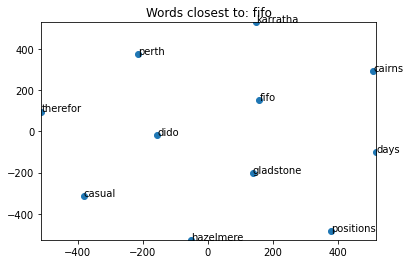

In [61]:
display_closestwords_tsnescatterplot(model.wv, 'fifo', 100)

/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


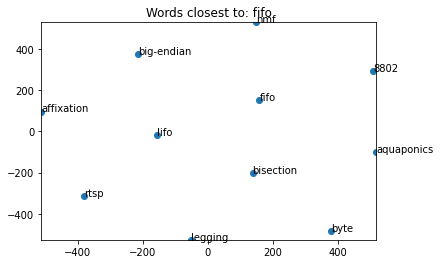

In [62]:
display_closestwords_tsnescatterplot(pretrained_wv, 'fifo', 200)

### Finding the top 10 words by tfidf score in each document and treating each category as its own corpus

Create_tfidf function creates a dataframe with each row representing a document with corresponding tfidf scores and the columns showing the full corpus vocabulary. Thus the tfidf score for each word in each document can be looked up.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Allows passing tokens to the vectorizer
def dummy_fun(doc):
    return doc

def create_tfidf_df(tokens):  
    tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None) 

    tdf = tfidf.fit_transform(tokens)
    bow = pd.DataFrame(tdf.toarray(), columns = tfidf.get_feature_names_out())

    return bow

Top x tfidf accepts a list of tokenized documents and removes all words that do not have the top x tfidf scores

Removes all words that do not have the top 10 tfidf scores. Treats each category as its own corpus

In [14]:
df['short_description'] = [None for i in range(len(df))]
def top_x_tfidf(df, x):
    for category in df.category.unique():
        tfidf_df = create_tfidf_df(df[df.category == category]['job_description'])
        for i, (idx_row) in enumerate(df[df.category == category].iterrows()):
            idx, row = idx_row
            desc = row['job_description']
            words = set(desc)        
            if len(words) < x: 
                df.loc[idx]['short_description'] = desc
                continue

            # Create a dictionary of words and their tfidf values and then sort them in descending order
            tfidf_words = {word: tfidf_df.iloc[i][word] for word in words}
            tfidf_words = {k: v for k, v in sorted(tfidf_words.items(), key=lambda item: -item[1])}

            for word in desc:
                if word not in list(tfidf_words.keys())[:x]: # Remove all words who are not in the top ten tfidf scores
                    desc = list(filter(lambda x: x != word, desc))
            df.loc[idx]['short_description'] = desc
    return df['short_description']


In [ ]:
top_x_tfidf(df, 10)

Split the dataframe into training, testing and validation

In [1]:
df

NameError: name 'df' is not defined

In [ ]:
train, test_val = train_test_split(df, test_size=0.3)

test, val = train_test_split(test_val, test_size = float(1/3))

# Task 1

Derive target variable

In [ ]:
df['job_type_target'] = df['job_type']

In [ ]:
df.loc[df['job_type_target'] != 'Full Time', 'job_type_target'] = 'Other'

Analyse class distribution

In [ ]:
df['job_type_target'].hist()

In [ ]:
# Class 'Full Time' is twice as large as 'Other'. Verify based on literature if such a distribution is too
# imbalanced for this learning task 

# Task 2